# Baseline Model

The primary question for our main research is whether it is possible to calculate the recovery time as accurately as possible. In the sections below we will set up a baseline model. Based on this model, we will determine afterwards whether it is possible to make a better model.

## Imports

In [15]:
from pandas import read_csv as pd_read_csv
from numpy import where as np_where
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

## Fetching

In [2]:
df = pd_read_csv("../Data/CSV/cleaned.csv", sep=';', low_memory=False)
oorzaakcodes = pd_read_csv('../Data/CSV/oorzaakcodes.csv', sep=';')
print(f'No less than {df.shape[0]} rows and {df.shape[1]} columns!')

No less than 252751 rows and 12 columns!


## Exploring

To begin with, it is important to extract basic information from the dataset. For example, presenting an insightful overview of the durations of all the repair work that has occured. It is also interesting to find out which repair work durations are most common, what the average duration is and what the median is.

Text(0, 0.5, 'frequentie')

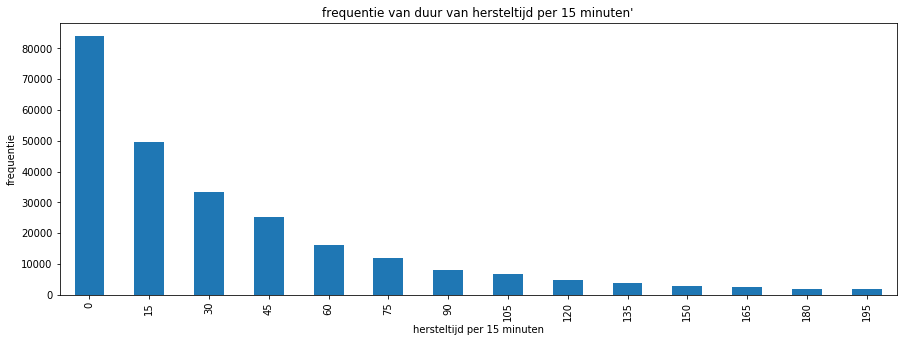

In [3]:
# presenteer staafdigram van meest voorkomende repairtimes.
series = df['hersteltijd_15'].value_counts()
series.plot(kind='bar', figsize=(15, 5))
plt.title("frequentie van duur van hersteltijd per 15 minuten'");
plt.xlabel("hersteltijd per 15 minuten")
plt.ylabel("frequentie")

This information indicates that the majority of the repairs are completed within 60 minutes. It can also be seen that there are few repairs that take longer than 60 minutes. 

On average, the recovery time of a restorative job is about 50 minutes. This finding was determined on the basis of data from ±300,000 activities. Of course we can immediately conclude that this average differs strongly per situation. This is also reinforced by the above bar chart which shows that most work is completed within 30 minutes.

In order to arrive at a more accurate forecast, it is important to gain more insight into the factors that influence the repair work. For example, the location and cause of the repair work can provide more insight into the repair time.

The question you can ask yourself is whether it is wise to ignore repair work that takes longer than 60 minutes. Or is an earlier or a later time frame the better endpoint? This question will be taken forward to a later phase of the research to find out which model results in the best outcome. In any case, we take the complete dataset into account for the baseline model.

In [4]:
#: Present information about number, duration and average of the duration of the repairs.
print('{0:50}  {1} repairs'.format('Total number of repairs:', len(df['hersteltijd'])))
print('{0:50}  {1} years'.format('Total recovery time of all repairs:', round(df['hersteltijd'].sum() / 60 / 24 / 365, 1)))
print('{0:50}  {1} minutes'.format('Most common repair time:', round(df["hersteltijd"].mode()[0], 1)))

mean = df["hersteltijd"].mean()
std = df["hersteltijd"].std()
print('{0:50}  between {1} and {2} minutes'.format('Time frame in which most repairs are completed:', max(0, mean - std), mean + std))

Total number of repairs:                            252751 repairs
Total recovery time of all repairs:                 20.5 years
Most common repair time:                            3 minutes
Time frame in which most repairs are completed:     between 0 and 85.71336729178648 minutes


We can see that most of the repairs(68,2%) take place in between 0 and 102 minutes.

The factor that we believe will have the most impact on recovery time is the reason code. Let us therefore provide more insight into this. To begin with, it is useful to be able to easily see the meaning of a given reason code. We will then identify the most common causes and present them visually.

In [5]:
#: Merges the cause codes with the descriptions.
df = df.merge(oorzaakcodes, left_on='oorzaakcode', right_on='Code').drop(['Code'], axis=1)

Text(0.5, 0, 'Frequentie:')

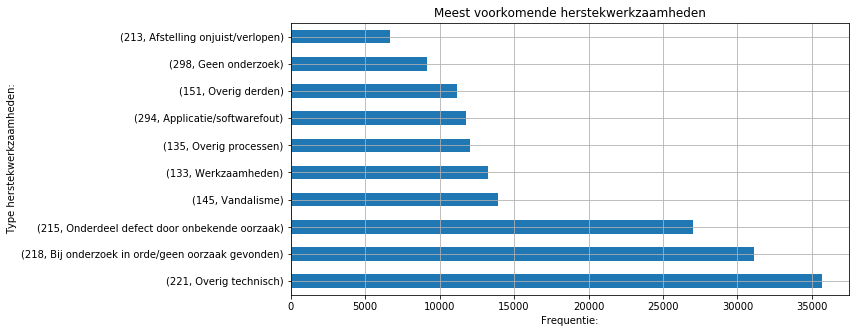

In [6]:
#: Determine most common reason codes and visualize most common reason codes
series = df['Oorzaak'].groupby(df['oorzaakcode']).value_counts()
series.nlargest(10).plot(kind="barh", stacked=True, figsize=(10, 5), grid=True)
plt.title("Meest voorkomende herstekwerkzaamheden")
plt.ylabel("Type herstekwerkzaamheden:")
plt.xlabel("Frequentie:")

In [7]:
series

oorzaakcode  Oorzaak                                    
130          Defect bijzonder voertuig tijdens transport       34
131          Uitloop treinvrije periode                        52
132          Ongepland werk                                   678
133          Werkzaamheden                                  13285
134          Aanrijding (bijna) tijdens werkzaamheden          78
                                                            ...  
242          Onvoldoende smering                              539
250          Belemmerende vegetatie                           208
294          Applicatie/softwarefout                        11796
298          Geen onderzoek                                  9140
299          Niet gemeld                                     1148
Name: Oorzaak, Length: 69, dtype: int64

We can extract a lot of new information from the above information. For example, it appears that cause 221 is technically common, but offers little insight into our primary question. Furthermore, we can come up with many more new findings.

Based on all the above information, we now have sufficient knowledge to concretely define and elaborate the baseline model. The baseline model will predict the recovery time as best as possible. The reason codes will be categorized so that it can be determined per category how long the repercussions of can last. Similarly, comments will be made based on the cause codes.

In [8]:
#: Categorized cause codes.
damage_defect_repair = [130, 132, 133, 136, 140, 144, 147, 149, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 
214, 215, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235, 239, 240, 241, 242, 250, 294]

nature = [181, 182, 183, 184, 185, 186, 187, 188, 189, 201]

loos = [135, 289, 299]

vandalism = [145, 154]

third_party = [131, 150, 151]

accident = [134, 141, 142, 143, 146, 148]

## Conclusion

If we would want to take it further we could use this data to determine the average repair time per category and categorize a new incident to this average, but for our baseline we want to keep it as easy and plain as possible so oure baseline model is 'all the repairtimes cost 3 minutes'.

In [9]:
# function to score repair time on how many repair times end in a given window. 
def range_score(van, tot):
    range_values = df[(df['hersteltijd'] >= van) & (df['hersteltijd'] < tot)]
    score = len(range_values) / len(df) * 100
    print(round(score, 4), '% van de storingen zijn binnen {} tot {} minuten opgelost.'.format(van, tot))

In [12]:
range_score(2.9, 3.1)
range_score(0, 5)
range_score(float(input('geef starttijd: ')), float(input('geef eindtijd: ')))

5.7266 % van de storingen zijn binnen 2.9 tot 3.1 minuten opgelost.
15.0979 % van de storingen zijn binnen 0 tot 5 minuten opgelost.
geef starttijd: 0
geef eindtijd: 30
50.2502 % van de storingen zijn binnen 0.0 tot 30.0 minuten opgelost.


6% of the predictions is exactly right, wich is pretty good. and you can see that 15% is very close to the predictions.
We can also check the mean squared error of oure baseline model.

In [16]:
# x and y vectors
x = df[['hersteltijd']]
y = df[['hersteltijd']].apply(lambda yy: yy * 0 + 5.0)

print(np.sqrt(mean_squared_error(x, y)))

57.20682460097469


The mean squared error is pretty high because the model only predicts 3 min, wich in on the low end of all the possible repairtimes (0min-360min).